In [2]:
#Importing Modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
#from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [3]:
#load the dataset
BASE_DIR = '../input/genderagedata/agegenderdata/'

In [4]:
#Labels - age,gender,ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/genderagedata/agegenderdata/19_1_0_20...,19,1
1,../input/genderagedata/agegenderdata/1_1_0_201...,1,1
2,../input/genderagedata/agegenderdata/21_1_0_20...,21,1
3,../input/genderagedata/agegenderdata/2_1_0_201...,2,1
4,../input/genderagedata/agegenderdata/1_1_0_201...,1,1


In [6]:
#mapping of labels for gender
gender_dict = {0:'Male', 1:'Female'}

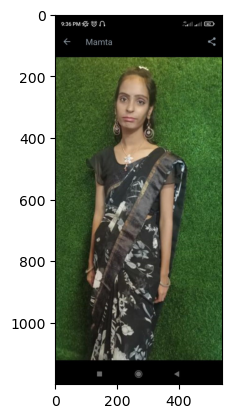

In [7]:
#Exploratory Data Analysis
from PIL import Image
img = Image.open(df['image'][0])
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

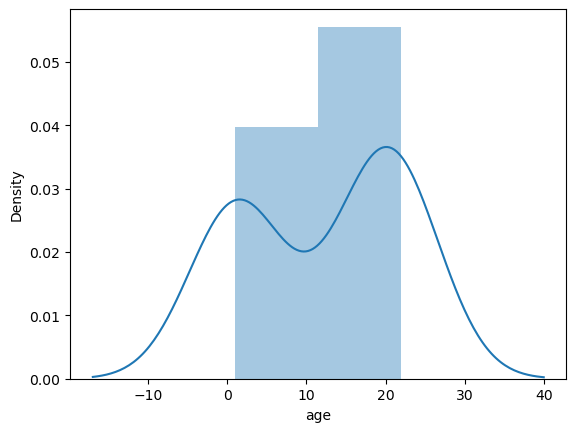

In [8]:
sns.distplot(df['age'])

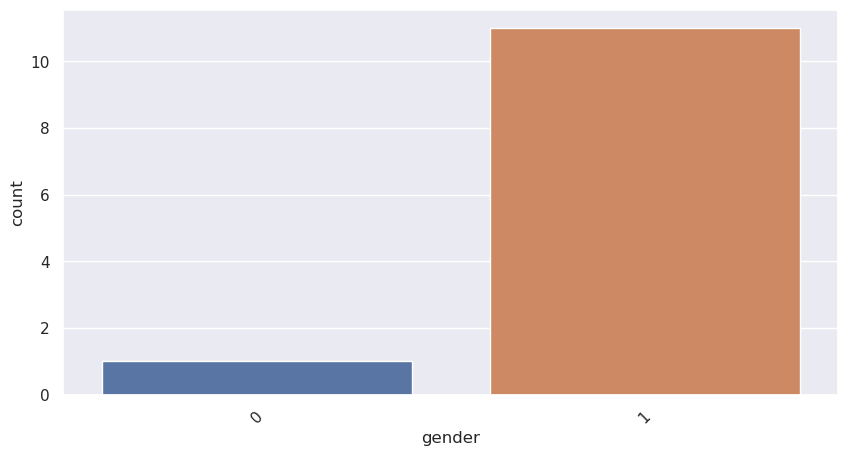

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid')
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='gender', data=df)
ax.set_xlabel('gender', fontsize=12)
plt.xticks(rotation=45)
plt.show()

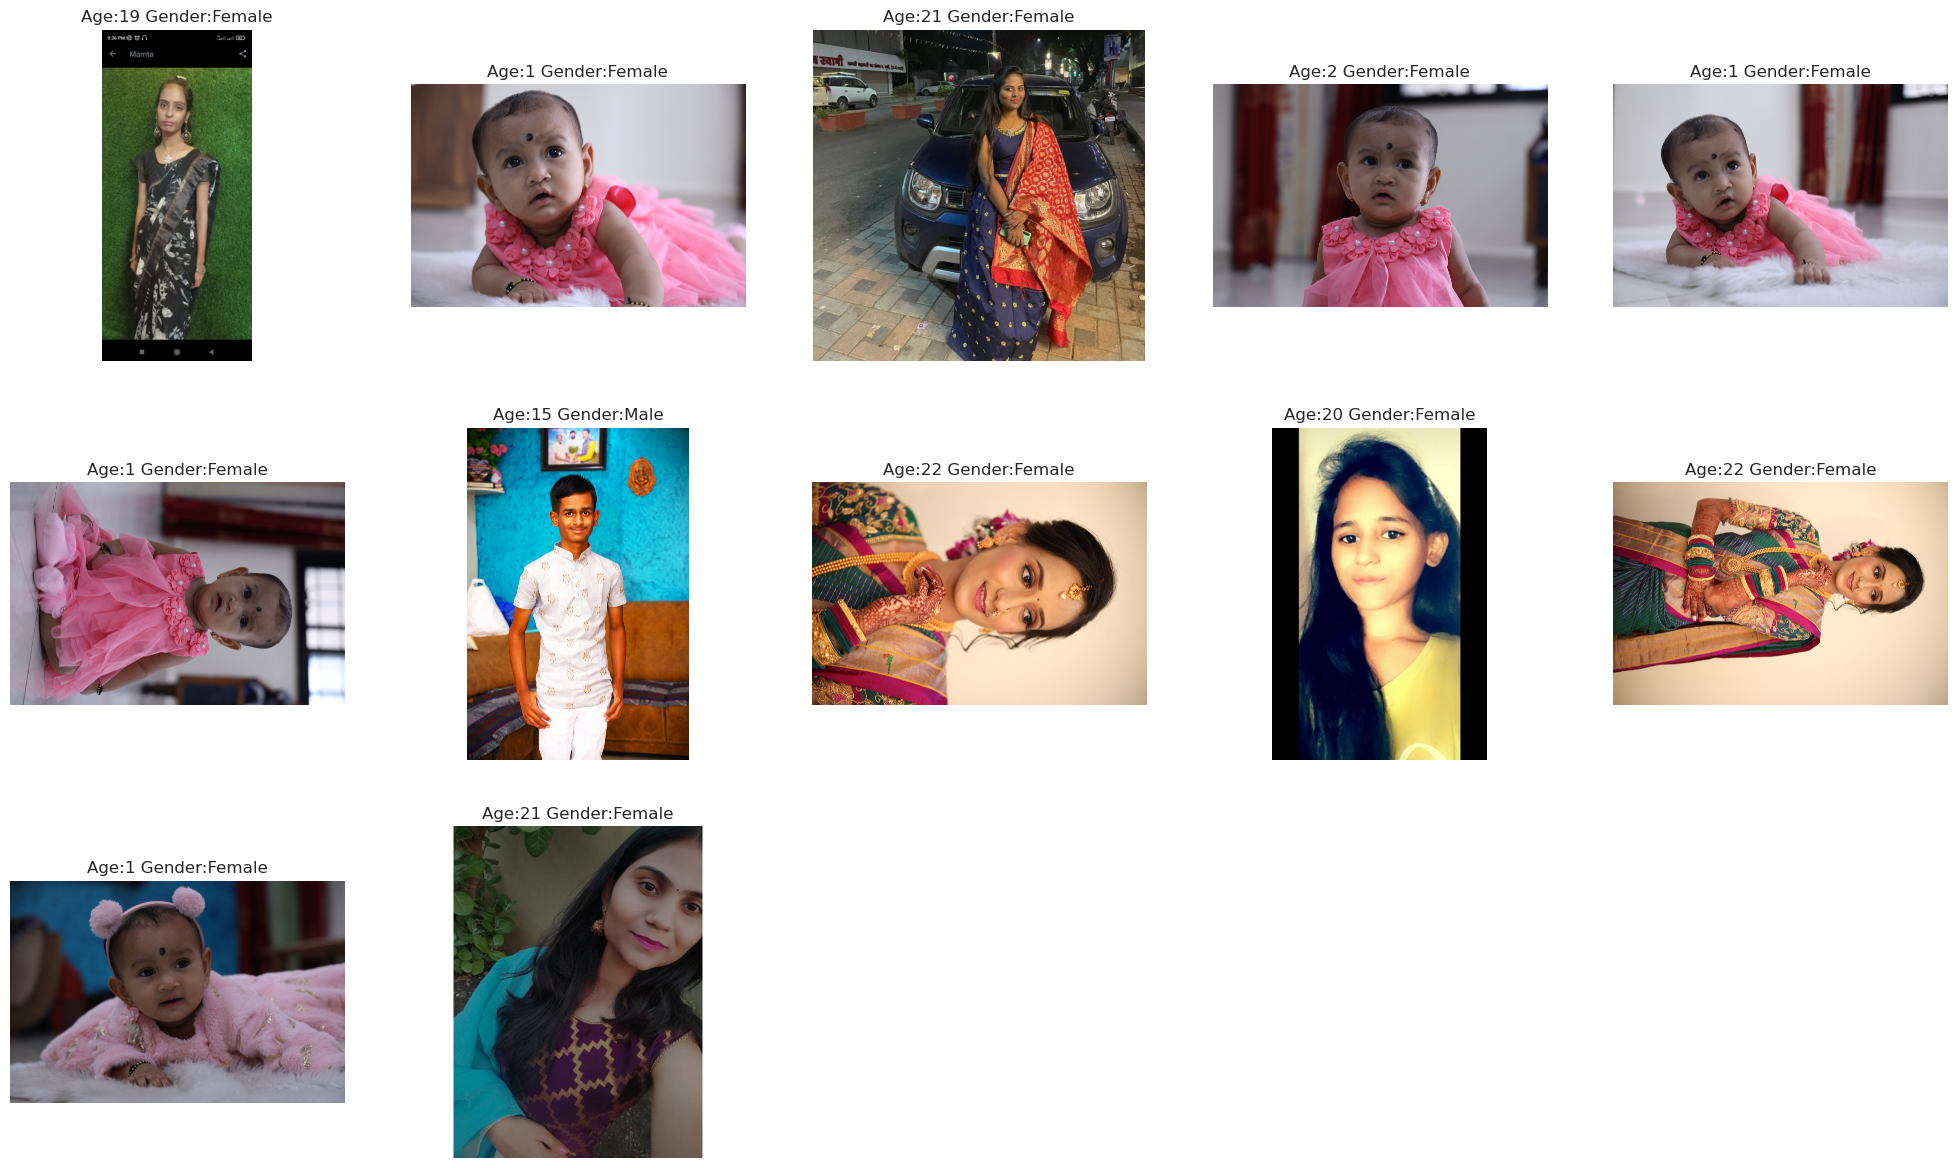

In [10]:
#To display grid of images
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    #img = load_img(file)
    img = plt.imread(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis('off')

In [11]:
import cv2
#Feature Extraction
def extract_features(images):
    features = []
    for image in tqdm(images):
       # img = plt.imread(image, grayscale=True)
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
import cv2

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [13]:
X = extract_features(df['image'])

  0%|          | 0/12 [00:00<?, ?it/s]

In [14]:
X.shape

(12, 128, 128, 1)

In [15]:
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128,128,1)

In [18]:
inputs = Input((input_shape))
# convolutional layers
#conv_0 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
#maxp_0 = MaxPooling2D(pool_size=(2, 2)) (conv_0)

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

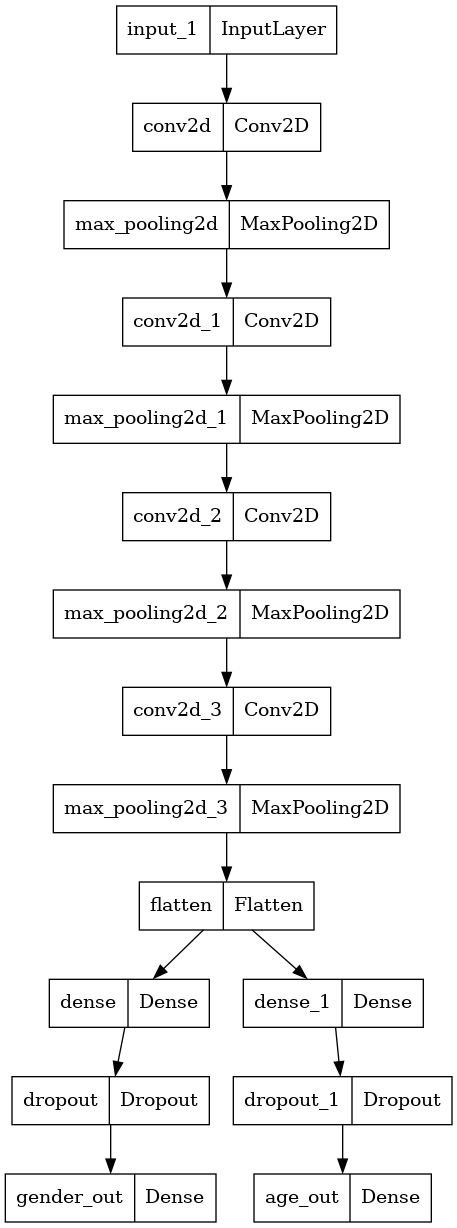

In [20]:
#Plotting model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [21]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=42, validation_split=0.2)

Epoch 1/42
1/1 [==============================] - 9s 9s/step - loss: 12.0231 - gender_out_loss: 0.6914 - age_out_loss: 11.3317 - gender_out_accuracy: 0.3333 - age_out_accuracy: 0.0000e+00 - val_loss: 13.8551 - val_gender_out_loss: 0.2673 - val_age_out_loss: 13.5878 - val_gender_out_accuracy: 1.0000 - val_age_out_accuracy: 0.3333
Epoch 2/42
1/1 [==============================] - 0s 49ms/step - loss: 10.5859 - gender_out_loss: 0.3894 - age_out_loss: 10.1965 - gender_out_accuracy: 0.8889 - age_out_accuracy: 0.3333 - val_loss: 11.8867 - val_gender_out_loss: 0.0099 - val_age_out_loss: 11.8768 - val_gender_out_accuracy: 1.0000 - val_age_out_accuracy: 0.3333
Epoch 3/42
1/1 [==============================] - 0s 45ms/step - loss: 10.0646 - gender_out_loss: 0.6827 - age_out_loss: 9.3820 - gender_out_accuracy: 0.8889 - age_out_accuracy: 0.3333 - val_loss: 9.0195 - val_gender_out_loss: 4.2160e-04 - val_age_out_loss: 9.0191 - val_gender_out_accuracy: 1.0000 - val_age_out_accuracy: 0.3333
Epoch 4/42

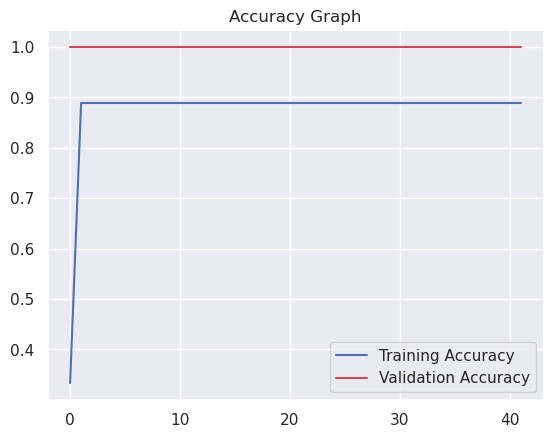

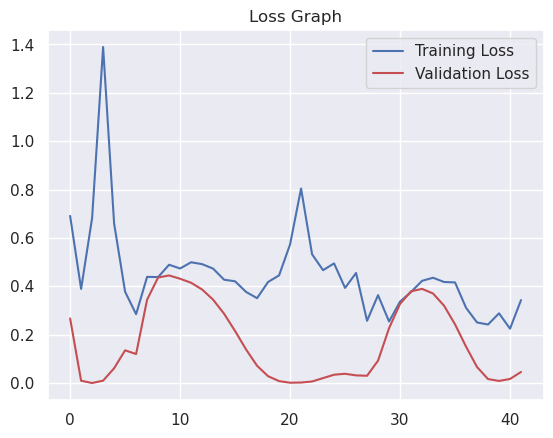

In [22]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

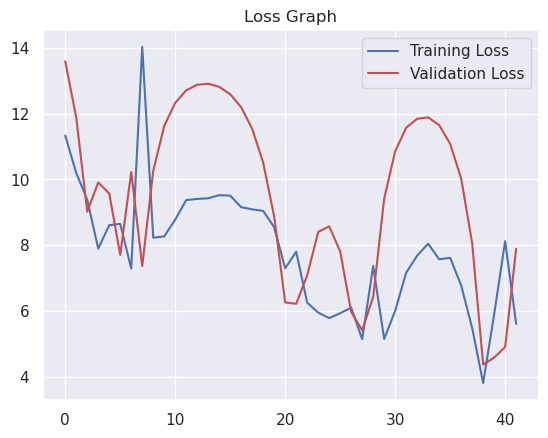

In [23]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 22
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: 13


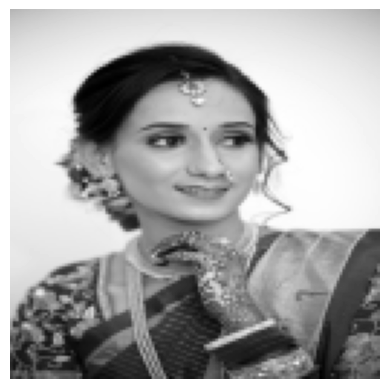

In [25]:
#prediction with test data
image_index = 7
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');